In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model


Mounted at /content/drive


In [2]:
# UPDATE these paths as needed
img_dir = '/content/drive/MyDrive/Brain/val_images'
mask_dir = '/content/drive/MyDrive/Brain/val_masks'

IMG_SIZE = 128


In [3]:
img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

print("Total images:", len(img_paths))
print("Total masks:", len(mask_paths))


Total images: 223
Total masks: 223


In [4]:
def load_images(paths, is_mask=False):
    arr = []
    for p in paths:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("Problem loading:", p)
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        if is_mask:
            img = (img > 127).astype('float32')  # binary mask

        arr.append(img)

    arr = np.array(arr).astype('float32') / 255.0
    return np.expand_dims(arr, -1)


In [5]:
X = load_images(img_paths)
Y = load_images(mask_paths, is_mask=True)

print('X shape:', X.shape)
print('Y shape:', Y.shape)


X shape: (223, 128, 128, 1)
Y shape: (223, 128, 128, 1)


In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )


In [8]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    return Model(inputs, outputs)


In [9]:
model = unet_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coef]
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=8
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 473ms/step - accuracy: 0.9823 - dice_coef: 0.0198 - loss: 0.3950 - val_accuracy: 0.9840 - val_dice_coef: 0.0011 - val_loss: 0.0091
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9831 - dice_coef: 0.0084 - loss: 0.0055 - val_accuracy: 0.9840 - val_dice_coef: 0.0105 - val_loss: 0.0023
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9823 - dice_coef: 0.0129 - loss: 0.0022 - val_accuracy: 0.9840 - val_dice_coef: 0.0352 - val_loss: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9839 - dice_coef: 0.0424 - loss: 7.7810e-04 - val_accuracy: 0.9840 - val_dice_coef: 0.0428 - val_loss: 6.3443e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9830 - dice_coef: 0.0545 - loss: 6.2057e-04 - val_accuracy: 0.9840 - val_dice_coef: 0.0715 - val_loss: 5.9067e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9814 - dice_coef: 0.0563 - loss: 6.8217e-04 - val_accuracy: 0.

In [11]:
model.save('unet_trained.h5')
model = tf.keras.models.load_model('unet_trained.h5', custom_objects={'dice_coef': dice_coef})


In [12]:
from google.colab import files
files.download('unet_trained.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

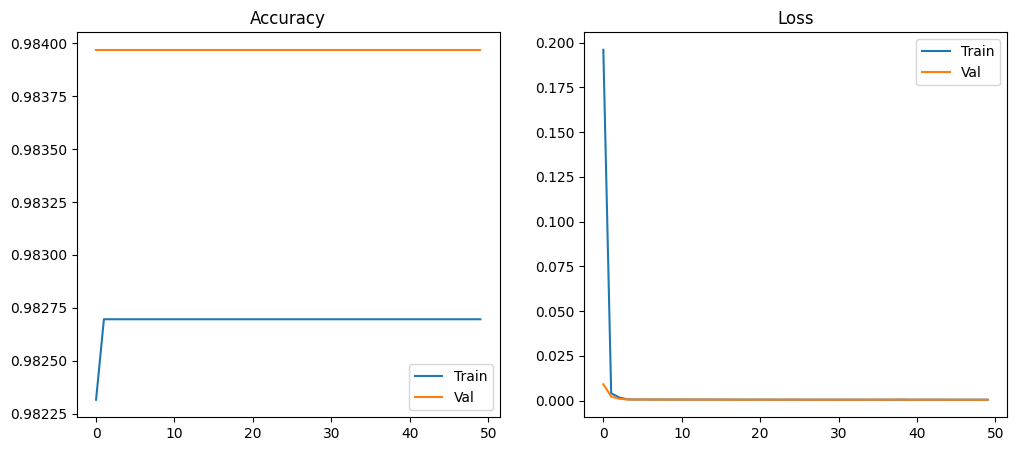

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train', 'Val'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train', 'Val'])

plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


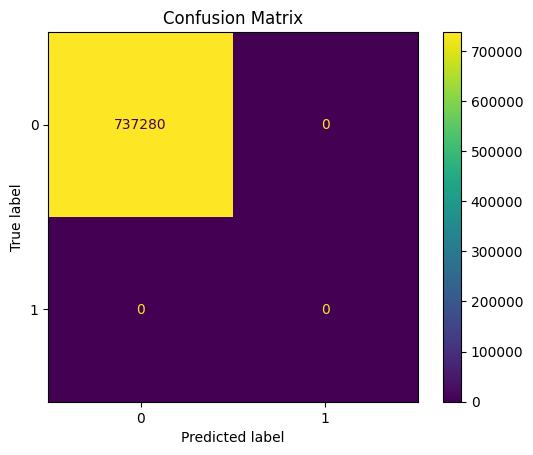

Precision: 0.0000
Recall: 0.0000
Dice Score: nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-349725873.py:19: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * intersection / (np.sum(y_true_flat) + np.sum(y_pred_flat))


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

y_true_flat = (Y_val.flatten() > 0.5).astype(np.uint8)
y_pred = model.predict(X_val)
y_pred_flat = (y_pred.flatten() > 0.5).astype(np.uint8)

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0,1])
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

intersection = np.sum(y_true_flat * y_pred_flat)
dice = 2 * intersection / (np.sum(y_true_flat) + np.sum(y_pred_flat))
print(f'Dice Score: {dice:.4f}')


In [34]:
def test_image_with_path(model, img_path, img_size=128):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error reading:", img_path)
        return

    img_resized = cv2.resize(img, (img_size, img_size))
    img_norm = img_resized.astype('float32') / 255.0

    input_img = np.expand_dims(img_norm, axis=[0, -1])
    pred_mask = model.predict(input_img)[0, :, :, 0]

    # Show raw probability map
    plt.imshow(pred_mask, cmap='jet')
    plt.colorbar()
    plt.title("Raw Prediction Mask")
    plt.show()

    plt.imshow(img_resized, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


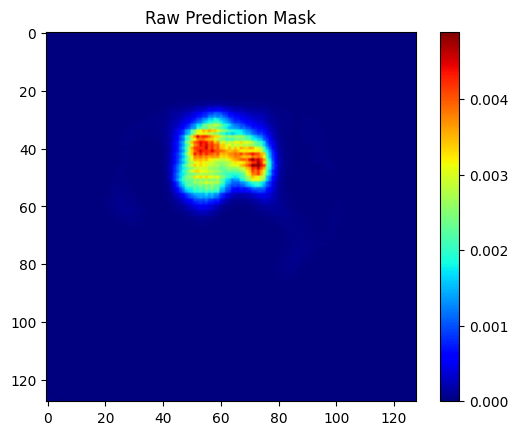

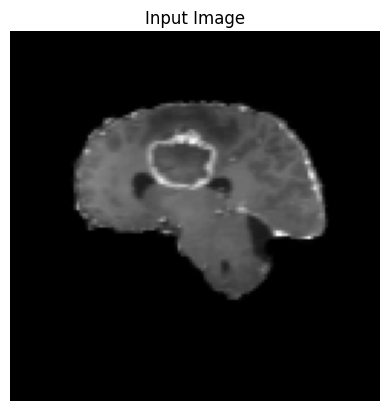

In [35]:
test_image_path = '/content/drive/MyDrive/Brain/val_images/val_1 (10).jpg'
test_image_with_path(model, test_image_path, IMG_SIZE)
